In [1]:
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
from utils import *

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression 

In [26]:
train_files = ["historical", "ssp126", "ssp370", "ssp585"]
X_train, eof_solvers = create_predictor_data(train_files)
# y_train = create_predictdand_data(train_files)

y_train = xr.open_dataset('/data/i4anders/Models/y_train/y_train.nc')

In [69]:
# y_train.compute()

In [70]:
X_train.head()

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
0,0.000020,0.039132,-1.070785,-0.107626,-0.571793,-1.272226,-0.051825,-0.348054,-1.280982,-1.068731,-0.392418,-0.362433
1,0.000040,0.039677,-1.070892,-0.104134,-0.577851,-1.246206,-0.069739,-0.344520,-1.280697,-1.061362,-0.404348,-0.379437
2,0.000060,0.040222,-1.073213,-0.117359,-0.553025,-1.242697,-0.067722,-0.346847,-1.278414,-1.057419,-0.402204,-0.379591
3,0.000082,0.040767,-1.075500,-0.130609,-0.528296,-1.238282,-0.065884,-0.348326,-1.276769,-1.054936,-0.401100,-0.380175
4,0.000107,0.041312,-1.087790,-0.214882,-0.368441,-1.335067,0.028653,-0.375174,-1.265988,-1.070907,-0.339490,-0.304372


In [30]:
y_test = xr.open_dataset('/data/climate-analytics-lab-shared//ClimateBench/CESM2_processed/outputs_ssp245.nc').mean(['month', 'member']).transpose('year', 'lat', 'lon')
X_test = get_test_data('ssp245', eof_solvers)

In [31]:
# truth values
y_train_tas = y_train['tas'].values.reshape(-1, 192 * 288)
tas_truth = y_test['tas']

y_train_pr = y_train['pr'].values.reshape(-1, 192 * 288)
y_test['pr'] *= 86400
pr_truth = y_test['pr']

y_train_huss = y_train['huss'].values.reshape(-1, 192 * 288)
huss_truth = y_test['huss']

y_train_hurs = y_train['hurs'].values.reshape(-1, 192 * 288)
hurs_truth = y_test['hurs']

y_train_rlds = y_train['rlds'].values.reshape(-1, 192 * 288)
rlds_truth = y_test['rlds']

y_train_rsds = y_train['rsds'].values.reshape(-1, 192 * 288)
rsds_truth = y_test['rsds']

y_train_wind = y_train['sfcWind'].values.reshape(-1, 192 * 288)
wind_truth = y_test['sfcWind']

y_train_ps = y_train['ps'].values.reshape(-1, 192 * 288)
ps_truth = y_test['ps']

# # filling nan (ocean grid points) with 0 for now
# y_train_mrsos = y_train['mrsos'].fillna(0.).values.reshape(-1, 192 * 288)
# mrsos_truth = y_test['mrsos']

# y_train_evspsbl = y_train['evspsbl'].values.reshape(-1, 192 * 288)
# evspsbl_truth = y_test['evspsbl']

## Predicting outputs from CO2 and CH4 (individually) 

#### For reference: LR with all inputs

In [33]:
var_names = ['tas', 'pr', 'huss', 'hurs', 'rlds', 'rsds', 'sfcWind', 'ps']
train_vars = [y_train_tas, y_train_pr, y_train_huss, y_train_hurs, y_train_rlds, y_train_rsds, y_train_wind, y_train_ps]
truth_vars = [tas_truth, pr_truth, huss_truth, hurs_truth, rlds_truth, rsds_truth, wind_truth, ps_truth]

for i in range(len(var_names)):
    lr = LinearRegression()
    lr_fit = lr.fit(X_train, train_vars[i])
    l_var = lr_fit.predict(X_test)
    l_out_var = l_var.reshape(86, 192, 288)
    
    print(f"{var_names[i]} rmse values")
    print(f"RMSE at 2050: {get_rmse(truth_vars[i][35], l_out_var[35]).mean()}")
    print(f"RMSE at 2100: {get_rmse(truth_vars[i][85], l_out_var[85]).mean()}")
    print(f"RMSE 2045-2055: {get_rmse(truth_vars[i][30:41], l_out_var[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(truth_vars[i][75:], l_out_var[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(truth_vars[i][35:], l_out_var[35:]).mean()}\n")



tas rmse values
RMSE at 2050: 0.838192292403337
RMSE at 2100: 1.0523104372114918
RMSE 2045-2055: 0.8978690329319252
RMSE 2090-2100: 0.9351118024016055
RMSE 2050-2100: 0.8539787733641242

pr rmse values
RMSE at 2050: 0.5149801605956595
RMSE at 2100: 0.7216651430511957
RMSE 2045-2055: 0.6093010082905357
RMSE 2090-2100: 0.7148333667525337
RMSE 2050-2100: 0.6812818205756165

huss rmse values
RMSE at 2050: 0.0004632469914070572
RMSE at 2100: 0.0006561359533411694
RMSE 2045-2055: 0.0005309674475099204
RMSE 2090-2100: 0.0005956185848879692
RMSE 2050-2100: 0.0005363001891898751

hurs rmse values
RMSE at 2050: 1.1669598030598278
RMSE at 2100: 1.3406969317874218
RMSE 2045-2055: 1.3069153116055927
RMSE 2090-2100: 1.3238550563541114
RMSE 2050-2100: 1.3193224423012662

rlds rmse values
RMSE at 2050: 4.689573388537352
RMSE at 2100: 5.925589741805971
RMSE 2045-2055: 5.179812083585825
RMSE 2090-2100: 5.4103370332623015
RMSE 2050-2100: 5.020137934216945

rsds rmse values
RMSE at 2050: 5.052836890165144

## For reference: LR with GMST

In [34]:
weights = np.cos(np.deg2rad(y_train.lat))
global_mean_temp = y_train['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

In [35]:
test_inputs = y_test['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()

In [36]:
test_inputs

year
2015    1.301202
2016    1.212808
2017    1.167027
2018    1.153813
2019    1.150449
          ...   
2096    3.338427
2097    3.361185
2098    3.374997
2099    3.391313
2100    3.412900
Length: 86, dtype: float64

In [71]:
for i in range(len(var_names)):
    reg_gmst = LinearRegression(fit_intercept=False)
    lr_var_gmst = reg_gmst.fit(global_mean_temp.to_numpy().reshape(-1, 1),train_vars[i])
    m_out_v = lr_var_gmst.predict(test_inputs.to_numpy()[:, np.newaxis])
    m_out_var = m_out_v.reshape(86, 192, 288)

    print(f"{var_names[i]} rmse values")
    print(f"RMSE at 2050: {get_rmse(truth_vars[i][35], m_out_var[35]).mean()}")
    print(f"RMSE at 2100: {get_rmse(truth_vars[i][85], m_out_var[85]).mean()}")
    print(f"RMSE 2045-2055: {get_rmse(truth_vars[i][30:41], m_out_var[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(truth_vars[i][75:], m_out_var[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(truth_vars[i][35:], m_out_var[35:]).mean()}\n")

tas rmse values
RMSE at 2050: 0.4027539185322775
RMSE at 2100: 0.4827689108757435
RMSE 2045-2055: 0.4613477727135819
RMSE 2090-2100: 0.4347426393690912
RMSE 2050-2100: 0.42887550355826076

pr rmse values
RMSE at 2050: 0.4124382061450687
RMSE at 2100: 0.5353599749341733
RMSE 2045-2055: 0.5134331703299284
RMSE 2090-2100: 0.5713283695858816
RMSE 2050-2100: 0.56794481077481

huss rmse values
RMSE at 2050: 0.0002112629279766039
RMSE at 2100: 0.0002676859503926351
RMSE 2045-2055: 0.000254867427824541
RMSE 2090-2100: 0.0002882072573009739
RMSE 2050-2100: 0.00027962707604655177

hurs rmse values
RMSE at 2050: 0.8763794177500348
RMSE at 2100: 0.8996845703377017
RMSE 2045-2055: 0.9977863607747466
RMSE 2090-2100: 0.9617589134612797
RMSE 2050-2100: 0.9739690601543282

rlds rmse values
RMSE at 2050: 2.391454269070217
RMSE at 2100: 2.648812779724693
RMSE 2045-2055: 2.8078036558465604
RMSE 2090-2100: 2.7390062739389305
RMSE 2050-2100: 2.6842921671639997

rsds rmse values
RMSE at 2050: 3.8376986318382

### CO2

In [38]:
y_inp_tas = y_train["tas"].stack(dim=["lat", "lon"])
y_inp_pr = y_train["pr"].stack(dim=["lat", "lon"])
y_inp_huss = y_train["huss"].stack(dim=["lat", "lon"])
y_inp_hurs = y_train["hurs"].stack(dim=["lat", "lon"])
y_inp_rlds = y_train["rlds"].stack(dim=["lat", "lon"])
y_inp_rsds = y_train["rsds"].stack(dim=["lat", "lon"])
y_inp_sfcWind = y_train["sfcWind"].stack(dim=["lat", "lon"])
y_inp_ps = y_train["ps"].stack(dim=["lat", "lon"])

In [45]:
yearly_CO2 = X_train['CO2'].values

In [46]:
reg0 = LinearRegression(fit_intercept=False)
reg1 = LinearRegression(fit_intercept=False)
reg2 = LinearRegression(fit_intercept=False)
reg3 = LinearRegression(fit_intercept=False)
reg4 = LinearRegression(fit_intercept=False)
reg5 = LinearRegression(fit_intercept=False)
reg6 = LinearRegression(fit_intercept=False)
reg7 = LinearRegression(fit_intercept=False)

lr_tas = reg0.fit(yearly_CO2.reshape(-1, 1),y_inp_tas)
lr_pr = reg1.fit(yearly_CO2.reshape(-1, 1),y_inp_pr)
lr_huss = reg2.fit(yearly_CO2.reshape(-1, 1),y_inp_huss)
lr_hurs = reg3.fit(yearly_CO2.reshape(-1, 1),y_inp_hurs)
lr_rlds = reg4.fit(yearly_CO2.reshape(-1, 1),y_inp_rlds)
lr_rsds = reg5.fit(yearly_CO2.reshape(-1, 1),y_inp_rsds)
lr_sfcWind = reg6.fit(yearly_CO2.reshape(-1, 1),y_inp_sfcWind)
lr_ps = reg7.fit(yearly_CO2.reshape(-1, 1),y_inp_ps)

In [47]:
test_CO2 = X_test['CO2'].values

In [48]:
m_out_t = lr_tas.predict(test_CO2[:, np.newaxis])
m_out_precip = lr_pr.predict(test_CO2[:, np.newaxis])
m_out_hus = lr_huss.predict(test_CO2[:, np.newaxis])
m_out_hur = lr_hurs.predict(test_CO2[:, np.newaxis])
m_out_rl = lr_rlds.predict(test_CO2[:, np.newaxis])
m_out_rs = lr_rsds.predict(test_CO2[:, np.newaxis])
m_out_sfc = lr_sfcWind.predict(test_CO2[:, np.newaxis])
m_out_p = lr_ps.predict(test_CO2[:, np.newaxis])

m_out_tas = m_out_t.reshape(86, 192, 288)
m_out_pr = m_out_precip.reshape(86, 192, 288)
m_out_huss = m_out_hus.reshape(86, 192, 288)
m_out_hurs = m_out_hur.reshape(86, 192, 288)
m_out_rlds = m_out_rl.reshape(86, 192, 288)
m_out_rsds = m_out_rs.reshape(86, 192, 288)
m_out_sfcWind = m_out_sfc.reshape(86, 192, 288)
m_out_ps = m_out_p.reshape(86, 192, 288)

In [49]:
print('tas: Near Surface Air Temperature')
print(f"RMSE 2080-2100: {get_rmse(tas_truth[65:], m_out_tas[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print('pr: Precipitation')
print(f"RMSE 2080-2100: {get_rmse(pr_truth[65:], m_out_pr[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

tas: Near Surface Air Temperature
RMSE 2080-2100: 0.4677735931629925
RMSE 2050-2100: 0.4432497800203699


pr: Precipitation
RMSE 2080-2100: 0.5707470771324785
RMSE 2050-2100: 0.5695636356149045




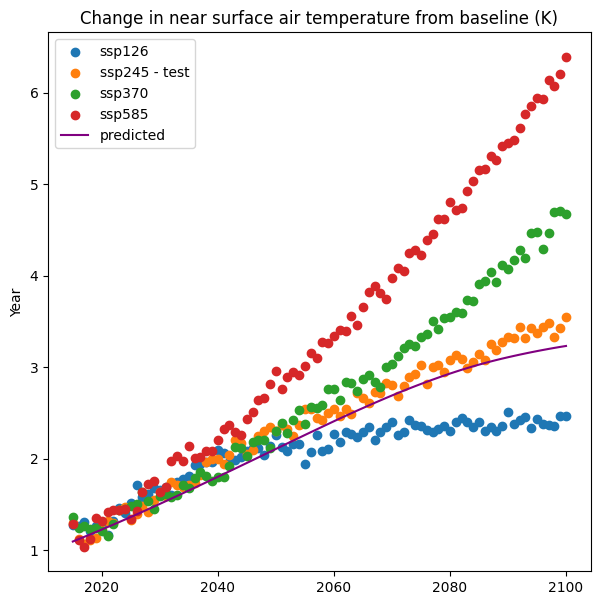

In [75]:
x = range(2015,2101)
tas_out = xr.DataArray(m_out_tas, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['tas'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['tas'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['tas'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['tas'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, tas_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.ylabel("Year")
plt.title("Change in near surface air temperature from baseline (K)")
plt.legend()

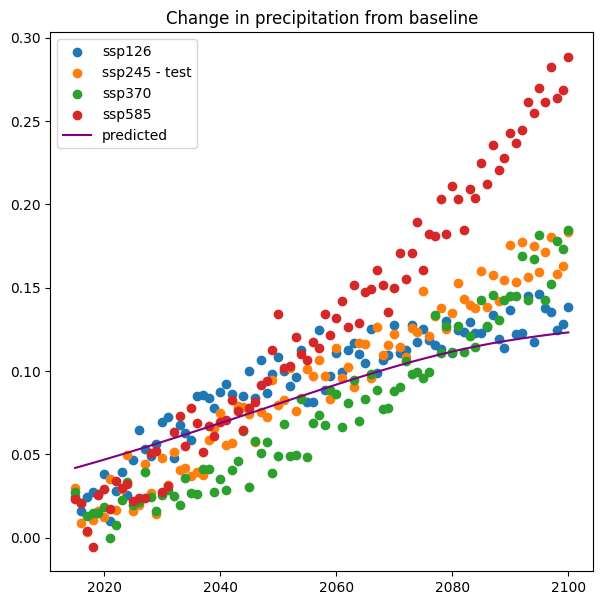

In [72]:
pr_out = xr.DataArray(m_out_pr, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['pr'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['pr'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['pr'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['pr'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, pr_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in precipitation from baseline")
plt.legend()

In [52]:
print('huss: Near Surface Specific Humidity')
print(f"RMSE 2080-2100: {get_rmse(huss_truth[65:], m_out_huss[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(huss_truth[35:], m_out_huss[35:]).mean()}")
print("\n")

print('hurs: Near Surface Relative Humidity')
print(f"RMSE 2080-2100: {get_rmse(hurs_truth[65:], m_out_hurs[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(hurs_truth[35:], m_out_hurs[35:]).mean()}")
print("\n")

huss: Near Surface Specific Humidity
RMSE 2080-2100: 0.00030504734025177437
RMSE 2050-2100: 0.00028636671642217666


hurs: Near Surface Relative Humidity
RMSE 2080-2100: 0.98168108929287
RMSE 2050-2100: 0.9802752423691796




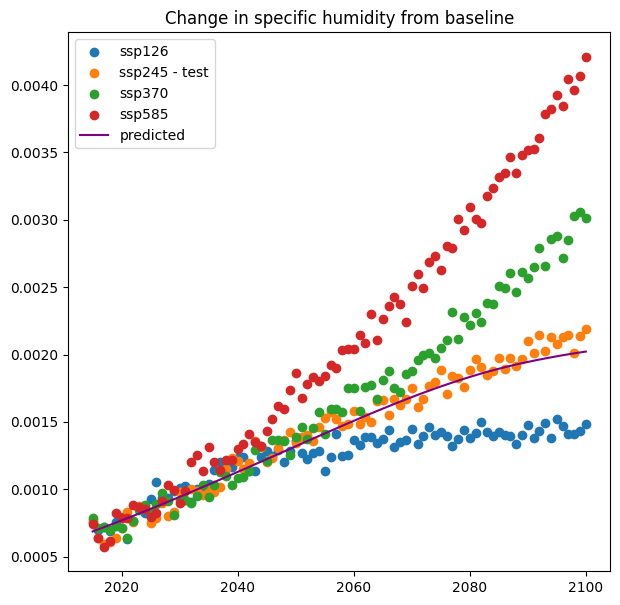

In [53]:
huss_out = xr.DataArray(m_out_huss, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['huss'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['huss'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['huss'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['huss'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, huss_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in specific humidity from baseline")
plt.legend()

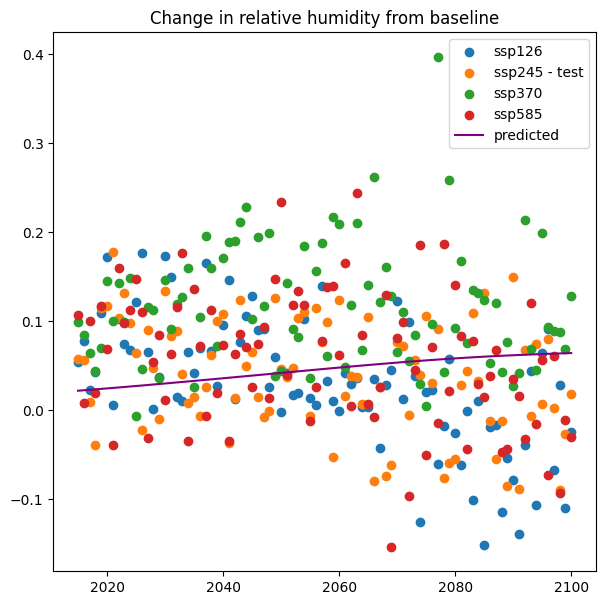

In [54]:
hurs_out = xr.DataArray(m_out_hurs, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['hurs'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['hurs'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['hurs'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['hurs'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, hurs_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in relative humidity from baseline")
plt.legend()

In [55]:
print('rlds: Surface Downwelling Longwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rlds_truth[65:], m_out_rlds[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(rlds_truth[35:], m_out_rlds[35:]).mean()}")
print("\n")

print('rsds: Surface Downwelling Shortwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rsds_truth[65:], m_out_rsds[65:]).mean()}")
print(f"RMSE 2500-2100: {get_rmse(rsds_truth[35:], m_out_rsds[35:]).mean()}")
print("\n")

rlds: Surface Downwelling Longwave Radiation
RMSE 2080-2100: 2.7921785921619025
RMSE 2050-2100: 2.736238794386351


rsds: Surface Downwelling Shortwave Radiation
RMSE 2080-2100: 4.8372032117322
RMSE 2500-2100: 4.634624464265279




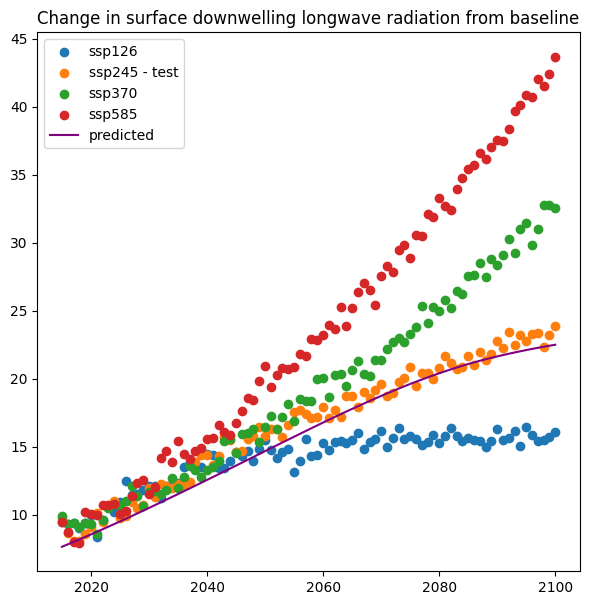

In [73]:
rlds_out = xr.DataArray(m_out_rlds, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['rlds'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['rlds'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['rlds'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['rlds'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, rlds_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in surface downwelling longwave radiation from baseline")
plt.legend()

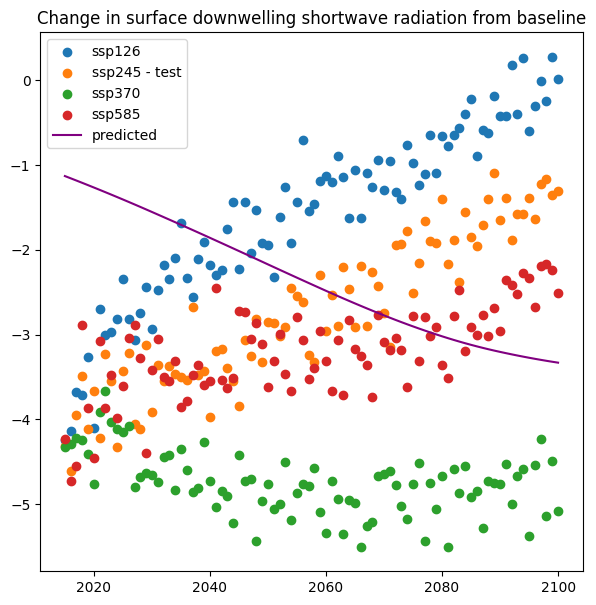

In [74]:
rsds_out = xr.DataArray(m_out_rsds, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['rsds'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['rsds'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['rsds'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['rsds'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, rsds_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in surface downwelling shortwave radiation from baseline")
plt.legend()

In [58]:
print('sfcWind: Near-Surface wind speed')
print(f"RMSE 2080-2100: {get_rmse(wind_truth[65:], m_out_sfcWind[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(wind_truth[35:], m_out_sfcWind[35:]).mean()}")
print("\n")

print('ps: surface air pressure')
print(f"RMSE 2080-2100: {get_rmse(ps_truth[65:], m_out_ps[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(ps_truth[35:], m_out_ps[35:]).mean()}")
print("\n")

sfcWind: Near-Surface wind speed
RMSE 2080-2100: 0.2041940165922074
RMSE 2050-2100: 0.20629681837231392


ps: surface air pressure
RMSE 2080-2100: 78.53282521399917
RMSE 2050-2100: 77.32324547108344




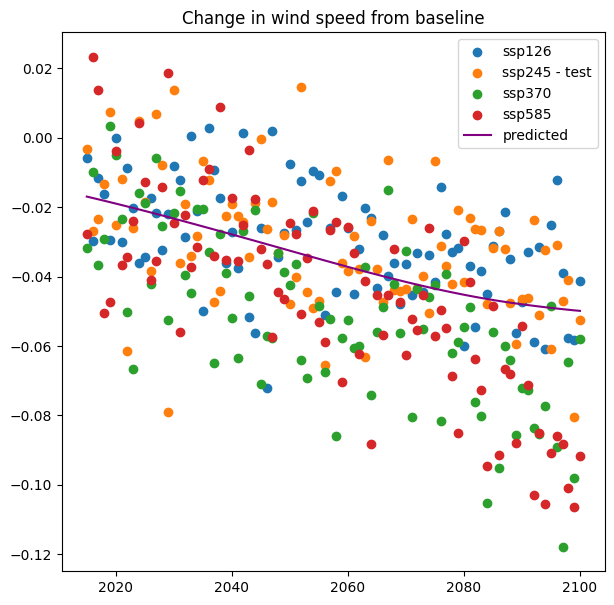

In [59]:
wind_out = xr.DataArray(m_out_sfcWind, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['sfcWind'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['sfcWind'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['sfcWind'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['sfcWind'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, wind_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in wind speed from baseline")
plt.legend()

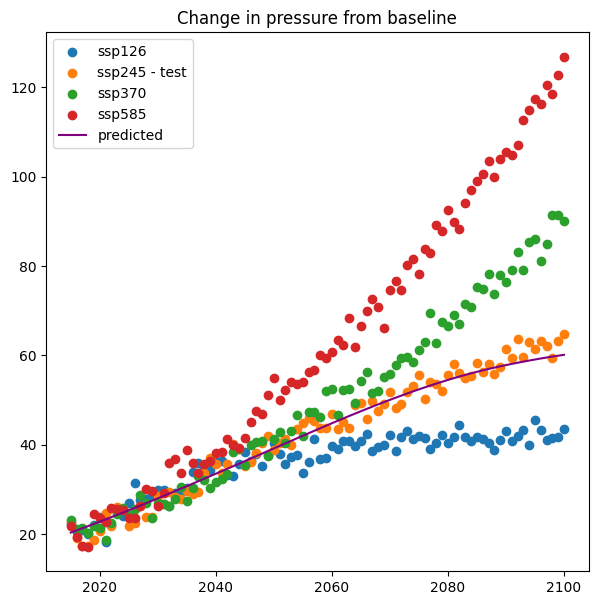

In [60]:
ps_out = xr.DataArray(m_out_ps, dims=('year', 'lat', 'lon'))

plt.figure(figsize=(7, 7))
plt.scatter(x, y_train['ps'][165:165+86].weighted(weights).mean(['lat', 'lon']), label='ssp126')
plt.scatter(x, y_test['ps'][:].weighted(weights).mean(['lat', 'lon']), label='ssp245 - test')
plt.scatter(x, y_train['ps'][165+86:165+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp370')
plt.scatter(x, y_train['ps'][165+86+86:165+86+86+86].weighted(weights).mean(['lat', 'lon']), label='ssp585')
plt.plot(x, ps_out.weighted(weights).mean(['lat', 'lon']), label='predicted', color = 'purple')
plt.title("Change in pressure from baseline")
plt.legend()

### CH4

In [61]:
yearly_ch4 = X_train['CH4'].values

In [62]:
reg0_ch4 = LinearRegression(fit_intercept=False)
reg1_ch4 = LinearRegression(fit_intercept=False)
reg2_ch4 = LinearRegression(fit_intercept=False)
reg3_ch4 = LinearRegression(fit_intercept=False)
reg4_ch4 = LinearRegression(fit_intercept=False)
reg5_ch4 = LinearRegression(fit_intercept=False)
reg6_ch4 = LinearRegression(fit_intercept=False)
reg7_ch4 = LinearRegression(fit_intercept=False)

lr_tas_ch4 = reg0.fit(yearly_ch4.reshape(-1, 1),y_inp_tas)
lr_pr_ch4 = reg1.fit(yearly_ch4.reshape(-1, 1),y_inp_pr)
lr_huss_ch4 = reg2.fit(yearly_ch4.reshape(-1, 1),y_inp_huss)
lr_hurs_ch4 = reg3.fit(yearly_ch4.reshape(-1, 1),y_inp_hurs)
lr_rlds_ch4 = reg4.fit(yearly_ch4.reshape(-1, 1),y_inp_rlds)
lr_rsds_ch4 = reg5.fit(yearly_ch4.reshape(-1, 1),y_inp_rsds)
lr_sfcWind_ch4 = reg6.fit(yearly_ch4.reshape(-1, 1),y_inp_sfcWind)
lr_ps_ch4 = reg7.fit(yearly_ch4.reshape(-1, 1),y_inp_ps)

In [63]:
test_ch4 = X_test['CH4'].values

In [64]:
m_out_t_ch4 = lr_tas_ch4.predict(test_ch4[:, np.newaxis])
m_out_precip_ch4 = lr_pr_ch4.predict(test_ch4[:, np.newaxis])
m_out_hus_ch4 = lr_huss_ch4.predict(test_ch4[:, np.newaxis])
m_out_hur_ch4 = lr_hurs_ch4.predict(test_ch4[:, np.newaxis])
m_out_rl_ch4 = lr_rlds_ch4.predict(test_ch4[:, np.newaxis])
m_out_rs_ch4 = lr_rsds_ch4.predict(test_ch4[:, np.newaxis])
m_out_sfc_ch4 = lr_sfcWind_ch4.predict(test_ch4[:, np.newaxis])
m_out_p_ch4 = lr_ps_ch4.predict(test_ch4[:, np.newaxis])

m_out_tas_ch4 = m_out_t_ch4.reshape(86, 192, 288)
m_out_pr_ch4 = m_out_precip_ch4.reshape(86, 192, 288)
m_out_huss_ch4 = m_out_hus_ch4.reshape(86, 192, 288)
m_out_hurs_ch4 = m_out_hur_ch4.reshape(86, 192, 288)
m_out_rlds_ch4 = m_out_rl_ch4.reshape(86, 192, 288)
m_out_rsds_ch4 = m_out_rs_ch4.reshape(86, 192, 288)
m_out_sfcWind_ch4 = m_out_sfc_ch4.reshape(86, 192, 288)
m_out_ps_ch4 = m_out_p_ch4.reshape(86, 192, 288)

In [65]:
print('tas: Near Surface Air Temperature')
print(f"RMSE 2080-2100: {get_rmse(tas_truth[65:], m_out_tas_ch4[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], m_out_tas_ch4[35:]).mean()}")
print("\n")

print('pr: Precipitation')
print(f"RMSE 2080-2100: {get_rmse(pr_truth[65:], m_out_pr_ch4[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], m_out_pr_ch4[35:]).mean()}")
print("\n")

tas: Near Surface Air Temperature
RMSE 2080-2100: 1.8904447795887975
RMSE 2050-2100: 1.4255728576709583


pr: Precipitation
RMSE 2080-2100: 0.673603103268456
RMSE 2050-2100: 0.6259888444926694




In [66]:
print('huss: Near Surface Specific Humidity')
print(f"RMSE 2080-2100: {get_rmse(huss_truth[65:], m_out_huss_ch4[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(huss_truth[35:], m_out_huss_ch4[35:]).mean()}")
print("\n")

print('hurs: Near Surface Relative Humidity')
print(f"RMSE 2080-2100: {get_rmse(hurs_truth[65:], m_out_hurs_ch4[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(hurs_truth[35:], m_out_hurs_ch4[35:]).mean()}")
print("\n")

huss: Near Surface Specific Humidity
RMSE 2080-2100: 0.0012319942404352376
RMSE 2050-2100: 0.0009067456081007456


hurs: Near Surface Relative Humidity
RMSE 2080-2100: 1.596331820934184
RMSE 2050-2100: 1.3813752553921315




In [67]:
print('rlds: Surface Downwelling Longwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rlds_truth[65:], m_out_rlds_ch4[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(rlds_truth[35:], m_out_rlds_ch4[35:]).mean()}")
print("\n")

print('rsds: Surface Downwelling Shortwave Radiation')
print(f"RMSE 2080-2100: {get_rmse(rsds_truth[65:], m_out_rsds_ch4[65:]).mean()}")
print(f"RMSE 2500-2100: {get_rmse(rsds_truth[35:], m_out_rsds_ch4[35:]).mean()}")
print("\n")

rlds: Surface Downwelling Longwave Radiation
RMSE 2080-2100: 11.920761921792415
RMSE 2050-2100: 9.016080491086527


rsds: Surface Downwelling Shortwave Radiation
RMSE 2080-2100: 5.90944462068251
RMSE 2500-2100: 5.318233487741054




In [68]:
print('sfcWind: Near-Surface wind speed')
print(f"RMSE 2080-2100: {get_rmse(wind_truth[65:], m_out_sfcWind_ch4[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(wind_truth[35:], m_out_sfcWind_ch4[35:]).mean()}")
print("\n")

print('ps: surface air pressure')
print(f"RMSE 2080-2100: {get_rmse(ps_truth[65:], m_out_ps_ch4[65:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(ps_truth[35:], m_out_ps_ch4[35:]).mean()}")
print("\n")

sfcWind: Near-Surface wind speed
RMSE 2080-2100: 0.26441496140294574
RMSE 2050-2100: 0.24384651752286868


ps: surface air pressure
RMSE 2080-2100: 103.58371704471645
RMSE 2050-2100: 92.2576231024285


